**This notebook comntains the baseline for Russian passport text recognition task. It based on [EAST Text Detector](https://github.com/argman/EAST) + [PyTesseract](https://github.com/madmaze/pytesseract).**

In [0]:
!sudo apt update
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev
!pip install pytesseract
!wget https://github.com/tesseract-ocr/tessdata/raw/master/rus.traineddata
!gunzip rus.traineddata
!sudo mv -v rus.traineddata /usr/share/tesseract-ocr/4.00/tessdata/


In [0]:
import os
import re
import cv2
import time
import math
import os
import imutils
import pytesseract
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from time import sleep

In [0]:
OUTPUT_SIZE = [3000, 4000]
IMAGES_PATH = '/content/drive/My Drive/Colab Notebooks/passports_parsing/data/my/'
RESULTS_DIR = '/content/drive/My Drive/Colab Notebooks/passports_parsing/EAST/results/'
PREPROCESSED_DIR = '/content/drive/My Drive/Colab Notebooks/passports_parsing/data/my/preprocessed/'
NET_CHECKPT_PATH = '/content/drive/My Drive/Colab Notebooks/passports_parsing/EAST/snaps/east_icdar2015_resnet_v1_50_rbox/'

**Image preprocessing:**

In [0]:
def get_contours(img):
  img = img.copy()
  grayed = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blured = cv2.medianBlur(grayed, 25)

  _, th = cv2.threshold(blured, 127, 255, cv2.THRESH_BINARY)

  _, contours, hierarchy = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

  img = cv2.drawContours(img, contours, -1, color=[255, 255, 255], thickness=20)
  max_area = np.NINF
  approxes = []
  i = 0
  
  for cnt in contours:
    epsilon = 0.1*cv2.arcLength(cnt,True)
    approx  = cv2.approxPolyDP(cnt,epsilon,True)
    approxes.append(approx)
    area    = cv2.contourArea(approx)
    if (area > max_area):
      max_area    = area
      ind = i
    i += 1
    
  return (approxes[ind])

def get_quarter(x, y, size):
  size_x, size_y = size[0], size[1]
  if ((x <= size_x/2.) & (y <  size_y/2.)):
    return 1
  if ((x <  size_x/2.) & (y >= size_y/2.)):
    return 2
  if ((x >= size_x/2.) & (y <  size_y/2.)):
    return 0
  if ((x >  size_x/2.) & (y >= size_y/2.)):
    return 3

def get_warped(img, bounds, out_size):
  img_copy = img.copy()
  x_max = out_size[0]
  y_max = out_size[1]
  src_pts = np.zeros((4, 2), dtype='float32')
  for bound in bounds:
    X, Y = bound[0]
    src_pts[get_quarter(X, Y, img_copy.shape)] = [X, Y]

  dest_pts = np.float32([[x_max, 0],  [0, 0],  [0, y_max],   [x_max, y_max]])
  
  matrix = cv2.getPerspectiveTransform(src_pts, dest_pts)
  result = cv2.warpPerspective(img, matrix, (x_max, y_max))
#   result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
  
  return result


In [0]:
for image_name in os.listdir(IMAGES_PATH):
  if os.path.isdir(IMAGES_PATH + image_name):
    continue
  image = cv2.imread(IMAGES_PATH + image_name)
  plt.imshow(image)
  plt.show()
  passport_bounds = get_contours(image)
  warped = get_warped(image, passport_bounds, OUTPUT_SIZE)
  plt.imshow(warped)
  cv2.imwrite(PREPROCESSED_DIR + image_name, warped)
  plt.figure(figsize=(10, 10))
  plt.show()


**Text detecting:**

In [0]:
os.chdir('/content/drive/My Drive/Colab Notebooks/passports_parsing/EAST')

import locality_aware_nms as nms_locality
import lanms
import model
from icdar import restore_rectangle

tf.app.flags.DEFINE_string('test_data_path', PREPROCESSED_DIR, '')
tf.app.flags.DEFINE_string('gpu_list', '0', '')
tf.app.flags.DEFINE_string('checkpoint_path', NET_CHECKPT_PATH, '')
tf.app.flags.DEFINE_string('output_dir', RESULTS_DIR, '')
tf.app.flags.DEFINE_bool('no_write_images', False, 'do not write images')

FLAGS = tf.app.flags.FLAGS


In [0]:
def get_images():
    '''
    find image files in test data path
    :return: list of files found
    '''
    files = []
    exts = ['jpg', 'png', 'jpeg', 'JPG']
    for parent, dirnames, filenames in os.walk(FLAGS.test_data_path):
        for filename in filenames:
            for ext in exts:
                if filename.endswith(ext):
                    files.append(os.path.join(parent, filename))
                    break
    print('Find {} images'.format(len(files)))
    return files


def resize_image(im, max_side_len=2400):
    '''
    resize image to a size multiple of 32 which is required by the network
    :param im: the resized image
    :param max_side_len: limit of max image size to avoid out of memory in gpu
    :return: the resized image and the resize ratio
    '''
    h, w, _ = im.shape

    resize_w = w
    resize_h = h

    # limit the max side
    if max(resize_h, resize_w) > max_side_len:
        ratio = float(max_side_len) / resize_h if resize_h > resize_w else float(max_side_len) / resize_w
    else:
        ratio = 1.
    resize_h = int(resize_h * ratio)
    resize_w = int(resize_w * ratio)

    resize_h = resize_h if resize_h % 32 == 0 else (resize_h // 32 - 1) * 32
    resize_w = resize_w if resize_w % 32 == 0 else (resize_w // 32 - 1) * 32
    resize_h = max(32, resize_h)
    resize_w = max(32, resize_w)
    im = cv2.resize(im, (int(resize_w), int(resize_h)))

    ratio_h = resize_h / float(h)
    ratio_w = resize_w / float(w)

    return im, (ratio_h, ratio_w)


# def detect(score_map, geo_map, timer, score_map_thresh=0.8, box_thresh=0.1, nms_thres=0.2):
def detect(score_map, geo_map, timer, score_map_thresh=0.95, box_thresh=0.1, nms_thres=0.2):

    '''
    restore text boxes from score map and geo map
    :param score_map:
    :param geo_map:
    :param timer:
    :param score_map_thresh: threshhold for score map
    :param box_thresh: threshhold for boxes
    :param nms_thres: threshold for nms
    :return:
    '''
    if len(score_map.shape) == 4:
        score_map = score_map[0, :, :, 0]
        geo_map = geo_map[0, :, :, ]
    # filter the score map
    xy_text = np.argwhere(score_map > score_map_thresh)
    # sort the text boxes via the y axis
    xy_text = xy_text[np.argsort(xy_text[:, 0])]
    # restore
    start = time.time()
    text_box_restored = restore_rectangle(xy_text[:, ::-1]*4, geo_map[xy_text[:, 0], xy_text[:, 1], :]) # N*4*2
    print('{} text boxes before nms'.format(text_box_restored.shape[0]))
    boxes = np.zeros((text_box_restored.shape[0], 9), dtype=np.float32)
    boxes[:, :8] = text_box_restored.reshape((-1, 8))
    boxes[:, 8] = score_map[xy_text[:, 0], xy_text[:, 1]]
    timer['restore'] = time.time() - start
    # nms part
    start = time.time()
    # boxes = nms_locality.nms_locality(boxes.astype(np.float64), nms_thres)
    boxes = lanms.merge_quadrangle_n9(boxes.astype('float32'), nms_thres)
    timer['nms'] = time.time() - start

    if boxes.shape[0] == 0:
        return None, timer

    # here we filter some low score boxes by the average score map, this is different from the orginal paper
    for i, box in enumerate(boxes):
        mask = np.zeros_like(score_map, dtype=np.uint8)
        cv2.fillPoly(mask, box[:8].reshape((-1, 4, 2)).astype(np.int32) // 4, 1)
        boxes[i, 8] = cv2.mean(score_map, mask)[0]
    boxes = boxes[boxes[:, 8] > box_thresh]

    return boxes, timer


def sort_poly(p):
    min_axis = np.argmin(np.sum(p, axis=1))
    p = p[[min_axis, (min_axis+1)%4, (min_axis+2)%4, (min_axis+3)%4]]
    if abs(p[0, 0] - p[1, 0]) > abs(p[0, 1] - p[1, 1]):
        return p
    else:
        return p[[0, 3, 2, 1]]


def main(argv=None):
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = FLAGS.gpu_list

    try:
        os.makedirs(FLAGS.output_dir)
    except OSError as e:
        if e.errno != 17:
            raise

    with tf.get_default_graph().as_default():
        input_images = tf.placeholder(tf.float32, shape=[None, None, None, 3], name='input_images')
        global_step = tf.get_variable('global_step', [], initializer=tf.constant_initializer(0), trainable=False)

        f_score, f_geometry = model.model(input_images, is_training=False)

        variable_averages = tf.train.ExponentialMovingAverage(0.997, global_step)
        saver = tf.train.Saver(variable_averages.variables_to_restore())

        with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
            ckpt_state = tf.train.get_checkpoint_state(FLAGS.checkpoint_path)
            model_path = os.path.join(FLAGS.checkpoint_path, os.path.basename(ckpt_state.model_checkpoint_path))
            print('Restore from {}'.format(model_path))
            saver.restore(sess, model_path)

            im_fn_list = get_images()
            for im_fn in im_fn_list:
                im = cv2.imread(im_fn)[:, :, ::-1]
                start_time = time.time()
                im_resized, (ratio_h, ratio_w) = resize_image(im)

                timer = {'net': 0, 'restore': 0, 'nms': 0}
                start = time.time()
                score, geometry = sess.run([f_score, f_geometry], feed_dict={input_images: [im_resized]})
                timer['net'] = time.time() - start

                boxes, timer = detect(score_map=score, geo_map=geometry, timer=timer)
                print('{} : net {:.0f}ms, restore {:.0f}ms, nms {:.0f}ms'.format(
                    im_fn, timer['net']*1000, timer['restore']*1000, timer['nms']*1000))

                if boxes is not None:
                    boxes = boxes[:, :8].reshape((-1, 4, 2))
                    boxes[:, :, 0] /= ratio_w
                    boxes[:, :, 1] /= ratio_h

                duration = time.time() - start_time
                print('[timing] {}'.format(duration))

                # save to file
                if boxes is not None:
                    res_file = os.path.join(
                        FLAGS.output_dir,
                        '{}.txt'.format(
                            os.path.basename(im_fn).split('.')[0]))

                    with open(res_file, 'w') as f:
                        for box in boxes:
                            # to avoid submitting errors
                            box = sort_poly(box.astype(np.int32))
                            if np.linalg.norm(box[0] - box[1]) < 5 or np.linalg.norm(box[3]-box[0]) < 5:
                                continue
                            f.write('{},{},{},{},{},{},{},{}\r\n'.format(
                                box[0, 0], box[0, 1], box[1, 0], box[1, 1], box[2, 0], box[2, 1], box[3, 0], box[3, 1],
                            ))
                            cv2.polylines(im[:, :, ::-1], [box.astype(np.int32).reshape((-1, 1, 2))], True, color=(255, 255, 0), thickness=1)
                if not FLAGS.no_write_images:
                    img_path = os.path.join(FLAGS.output_dir, os.path.basename(im_fn))
                    cv2.imwrite(img_path, im[:, :, ::-1])


In [0]:
if __name__ == '__main__':
    tf.app.run()

**Decoding text:**

0uNUO3xVlno.JPG:


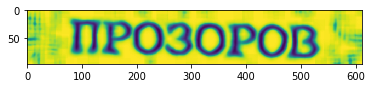

ПРОЗОРОВ


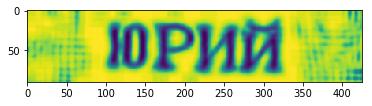

ЮРИЙ


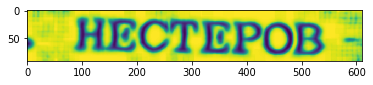

НЕСТЕРОВ

IMG_9922.JPG:


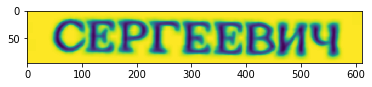

СЕРГЕЕВИЧ


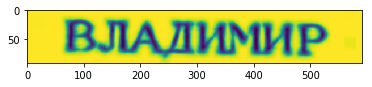

ВЛАЛИМИРО


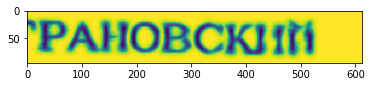

РАНОВСКИЙ

IMG_9919.JPG:


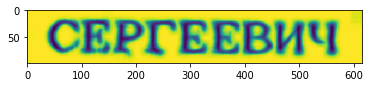

СЕРГЕЕВИЧ_


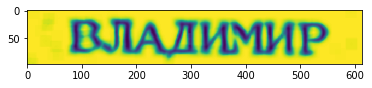

ВЛАЛИМИРО

IMG_9920.JPG:


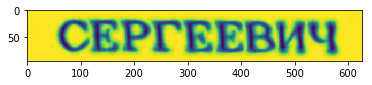

СЕРГЕЕВИЧ


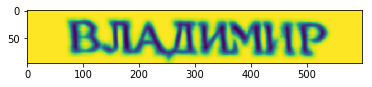

ВЛАДИМИРО


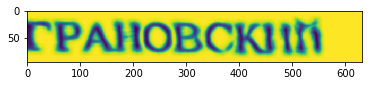

ГРАНОВСКИЙ

IMG_9921.JPG:


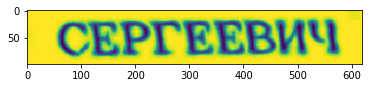

СЕРГЕЕВИЧ


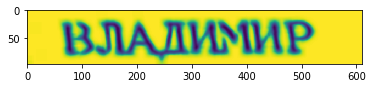

ВЛАДИМИР


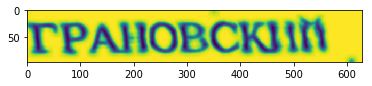

ГРАНОВСКУМ

sample_img.JPG:


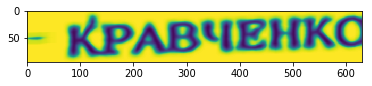

КРАВЧЕНКС


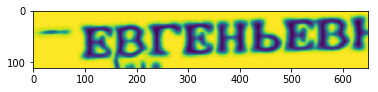

ЕВГЕНЬЕВ!


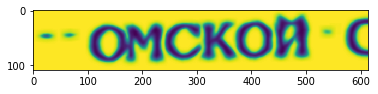

ОМСКОЙ(



In [0]:
for result_file in os.listdir(RESULTS_DIR):
  if result_file.split('.')[1] == 'txt':
    img_file = IMAGES_PATH + 'preprocessed/' + result_file.split('.')[0] + '.JPG'
    img = cv2.imread(img_file, cv2.CV_8UC1)
    with open(RESULTS_DIR + result_file) as text_file:
      text = text_file.readlines()

      rows = []
      lines = []
      bounds = []

      for row in text: 
        rows.append(row[:-1].split(','))

      for row in rows:
        line = []
        for i in range(0, 8, 2):
          line.append([row[i], row[i+1]])
        lines.append(line)

      for line in lines:
        pts = np.zeros((4, 2))
        i = 0
        for pt in line:
          pts[i] = np.array(pt)
          i += 1 
        y_min = int(np.min(pts[:, 1])) - 15
        y_max = int(np.max(pts[: ,1])) + 15
        x_min = int(np.min(pts[:, 0])) - 100
        x_max = int(np.max(pts[:, 0])) + 100
        bounds.append(img[y_min:y_max, x_min:x_max])

      print(result_file.split('.')[0] + '.JPG:')
      for bnd in bounds[:3]:
        try:
          bnd = cv2.adaptiveThreshold(bnd, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,101,9) 
          bnd = cv2.fastNlMeansDenoising(bnd, None, 100, 21, 21)
        except:
          continue
        plt.imshow(bnd)
        plt.show()
        sleep(1)
        text = pytesseract.image_to_string(bnd, lang='rus', config="--psm 8")
#         text = pytesseract.image_to_string(bnd, lang='rus', config="--psm 11") 
#         text = pytesseract.image_to_string(bnd, lang='rus', config="--psm 13") 
        text = re.sub(r"[—‹*'‚.<>`,-:›° ]", "", text)
        print(text)
      print()
  
# defaults:
  # psm 8
  # bnd = cv2.adaptiveThreshold(bnd,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,91,10)
  # bnd = cv2.adaptiveThreshold(bnd,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,61,2) 